In [1]:
!pip install livelossplot==0.5.1 --quiet

import gc
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import cv2 as cv
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from skimage.transform import resize 
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from livelossplot import PlotLosses

import os
from os import listdir
from sys import getsizeof

In [2]:
class h5DatasetSlice(Dataset):

    def __init__(self, file_path, func=None, portion=(0, 1)):
        '''
        h5DatasetSlice creates a custom dataset object and allows for slicing
        of the source data to produce training, validation, and testing sets.
        An optional parameter 'func' can be passed in for data augmentation.
        '''
        
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")
        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        portion = [int(k*len(self.rgb_dbs)) for k in portion]

        self.rgb_dbs = self.rgb_dbs[portion[0] : portion[1]]
        self.depth_dbs = self.depth_dbs[portion[0] : portion[1]]
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        rgb = self.file[self.rgb_dbs[index]][:]
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        else:
            rgb = self.totens(rgb)
            depth = self.totens(depth.astype(np.float64) / 65535.0)
            
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

def alter(rgb, depth):

    totens = transforms.ToTensor()

    rgb = TF.center_crop(Image.fromarray(rgb), (400, 533))
    depth = TF.center_crop(Image.fromarray(depth), (400, 533))
    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def alter_val(rgb, depth):
    '''
    alter_val augments the dataset by cropping but avoids rotations or flips
    '''

    totens = transforms.ToTensor()

    rgb = TF.center_crop(Image.fromarray(rgb), (400, 533))
    depth = TF.center_crop(Image.fromarray(depth), (400, 533))
    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def load_dataset(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):
    train_data = h5DatasetSlice(file_path=file_path, func=alter, 
                                portion=(0, ratios[0]))
    val_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0], ratios[0]+ratios[1]))
    test_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0]+ratios[1], 1))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

In [3]:
filepath = "/content/drive/My Drive/APS360_Project/Data/"

In [22]:
class SkipUpconv2(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv2, self).__init__()

        mid_channels = (in_channels + out_channels) // 2
        self.activ = activ
        #self.norm1 = nn.BatchNorm2d(mid_channels)
        #self.norm2 = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels = mid_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        x = self.activ(self.conv1(torch.cat((scaled, big), dim=1)))
        x = self.activ(self.conv2(x))

        return F.interpolate(x, scale_factor=2, mode='bilinear', 
                             align_corners=True)

def vecinfo(vec):
    totens = transforms.ToTensor()
    try:
        vec = totens(vec)
    except:
        pass
    print("min: {}, max: {}, mean: {}".format(
        torch.min(vec),
        torch.max(vec),
        torch.mean(vec)
    ))


def random_crop(data, size):
    rgb, depth = data
    h, w = rgb.shape[:2]
    new_h, new_w = size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    rgb = rgb[top: top + new_h,
              left: left + new_w]
    depth = depth[top: top + new_h,
                  left: left + new_w]
    
    return rgb, depth

def random_rotate(data, max_angle, resample=False, expand=False, 
                  center=None, fill=None):
    rgb, depth = data
    rgb = Image.fromarray(rgb)
    depth = Image.fromarray(depth)
    angle = np.random.uniform(-max_angle, max_angle)
    return (TF.rotate(rgb, angle, resample, expand, center, fill),
            TF.rotate(depth, angle, resample, expand, center, fill))

def random_hflip(data, p=0.5):
    rgb, depth = data

    if torch.rand(1) < p:
        return TF.hflip(rgb), TF.hflip(depth)
    
    return rgb, depth

def valid_loss(model, criterion, val_loader, index):

    model.eval()

    with torch.no_grad():

        for i, (rgb, depth) in enumerate(val_loader, \
                                         index % (len(val_loader) - 1)):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())
            del rgb

            return torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()


def train(model, batch_size=16, lr=0.01, num_epochs=1, ratios=(.8, .1, .1),
          load_pretrained=False):

    plotlosses = PlotLosses(groups={'Loss': ['train', 'val']})
    
    torch.manual_seed(1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    checkpoint_filepath = "/content/drive/My Drive/Checkpoints/demo_model.pth"

    if not os.path.exists(os.path.dirname(checkpoint_filepath)):
      print("Checkpoint folder not found. Creating new folder")
      os.makedirs(os.path.dirname(checkpoint_filepath))
    else:
      print("Checkpoint folder found.")

    if load_pretrained and os.path.exists(checkpoint_filepath):
      checkpoint = torch.load(checkpoint_filepath)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      print("Resuming training from epoch",checkpoint['epoch'],"\nLoss:", checkpoint['loss'])
    else:
      print("No previous checkpoint file found.")

    print("Loading data...")
    train_loader, val_loader = load_dataset(
      file_path=filepath,
      batch_size=batch_size,
      ratios=ratios
      )[:2]
    print("Data loading complete")

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader):

            model.train()

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):

                pred = model(rgb.float())
                loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))

                gc.collect()
            
                loss.backward()
                optimizer.step()

            val_loss = valid_loss(model, nn.MSELoss(), val_loader, i)

            plotlosses.update({
                'train': loss.item(),
                'val': val_loss
            })
            plotlosses.send()
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()

In [14]:
class SkipEncoder6(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(SkipEncoder6, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        '''
        the numbers added to the input channels are the number of channels in 
        the mobilenet layers that will be 
        '''
        self.dec2 = SkipUpconv2(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv2(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv2(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv2(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        '''
        passes the rgb image into mobilenet and appends the output of each layer
        into the features list. This saves the progress of the feature maps
        as they progress through the network. Any of those outputs can be fed 
        into dec1, dec2, etc. which are objects of the SkipUpconv class. 
        Basically this allows us to have skip connections from inside the 
        pretrained model encoder going into the custom layers in the decoder.
        Use this code to better understand the features list and how to properly 
        index it to extract the outputs you want:

        for feature in features:
            print(feature.shape)
        
        note: put this after the for loop below
        '''
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        '''
        introduce skip connections from the encoder into the decoder portion of
        the model. This allows the trainable decoder to have access to less 
        processed and less abstract versions of the input image, which makes it 
        better at capturing geometric details. There are also two normalizations 
        spread out between the upconvolutions.
        '''
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)

# Skip Encoder 6

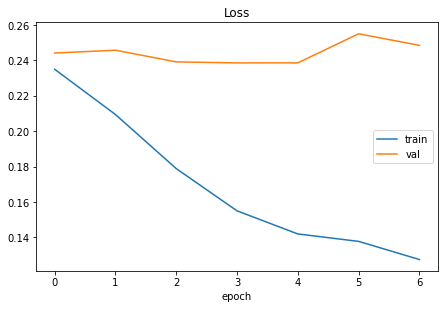

Loss
	train            	 (min:    0.127, max:    0.235, cur:    0.127)
	val              	 (min:    0.239, max:    0.255, cur:    0.248)


KeyboardInterrupt: ignored

In [23]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc6 = SkipEncoder6()

print(sum(p.numel() for p in skipenc6.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc6.cuda()

#TRAIN FOR AROUND 300 BATCHES OR SO

train(skipenc6, batch_size=32, lr=1e-4, num_epochs=5, ratios=(.8, .15, .05), load_pretrained= False)